In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
%load_ext tensorboard
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

Num GPUs Available:  0


In [2]:
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Conv1D, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional, TimeDistributed
from keras import regularizers
from datetime import datetime
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
# from kerastuner.tuners import RandomSearch

# Data generation

In [3]:
import cars_generate
from cars_generate import cars_generating

def data_feature_generation(sample_size, max_feature):
    cars= cars_generating(max_feature,640)
    data= cars.generate_batch(sample_size) 
    x, y= data[0],data[1]
    return x.reshape((-1,640)), y.reshape((-1,640))

def split_data(sample_size, split_size, n_batch=14):
    x_train, x_test, y_train, y_test= [],[],[],[]
    n_samples=int(sample_size/n_batch)
    for i in range(1,n_batch+1):
        x,y= data_feature_generation(n_samples,i)
        x_train.append(x[:int(split_size*n_samples)])
        x_test.append(x[int(split_size*n_samples):])
        y_train.append(y[:int(split_size*n_samples)])
        y_test.append(y[int(split_size*n_samples):])
    x_train, y_train=np.array(x_train), np.array(y_train)
    x_test, y_test= np.array(x_test), np.array(y_test)
    return x_train.reshape((-1,640)), x_test.reshape((-1,640)), y_train.reshape((-1,640)), y_test.reshape((-1,640))
 
def shuffle_data(x_train, x_test,y_train, y_test):
    index_train=random.sample([i for i in range(len(x_train))], len(x_train))
    index_test=random.sample([i for i in range(len(x_test))], len(x_test))
    return x_train[index_train], x_test[index_test],y_train[index_train], y_test[index_test]

def generate_csv(x, name):
    x=pd.DataFrame(x)
    return x.to_csv(name+'.csv')

In [ ]:
x_train, x_test, y_train, y_test=split_data(20000, 2/3, 15)
x_train, x_test, y_train, y_test=shuffle_data(x_train, x_test, y_train, y_test)

# upload csv

In [22]:
import os
# dire= os.mkdir('Data')
# generate_csv(x_train.reshape((-1,640)), 'Data/x_train')
# generate_csv(y_train.reshape((-1,640)), 'Data/y_train')
# generate_csv(x_test.reshape((-1,640)),'Data/x_test')
# generate_csv(y_test.reshape((-1,640)), 'Data/y_test')

## Download Data

In [3]:
x_train= pd.read_csv('Data/x_train.csv', index_col=0).to_numpy()
x_test= pd.read_csv('Data/x_test.csv', index_col=0).to_numpy()
y_train= pd.read_csv('Data/y_train.csv',index_col=0).to_numpy()
y_test= pd.read_csv('Data/y_test.csv',index_col=0).to_numpy()

In [4]:
x_train.shape, x_test.shape

((13320, 640), (6675, 640))

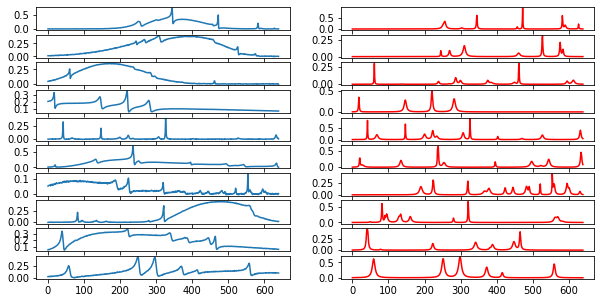

In [5]:
f, a= plt.subplots(10,2, figsize= (10,5))
for i in range(len(a)):
  a[i,0].plot(x_train[i*200])
  a[i,1].plot(y_train[i*200], c='r')
plt.savefig("data.jpeg")

In [12]:
x_train, y_train= x_train.reshape((-1,640,1)), y_train.reshape((-1,640,1))
x_train.shape, y_train.shape

((13320, 640, 1), (13320, 640, 1))

# LSTM

### LSTM architecture

In [12]:
steps= 640
feature=1
logdir_lstm = "logs/scalars/lstm" + datetime.now().strftime("%Y%m%d-%H%M%S")
tf.keras.backend.clear_session()
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir_lstm)
es =tf.keras.callbacks.EarlyStopping(monitor='loss', patience=6, mode= 'min', min_delta=0.0001, verbose=1)
mc = ModelCheckpoint('lstm.h5', monitor='val_loss', mode='min', save_best_only=True)
rmse=tf.keras.metrics.RootMeanSquaredError(name='rmse')
tf.keras.backend.clear_session()
Model=Sequential()
Model.add(LSTM(units=50, return_sequences=True, input_shape=(steps,feature)))
Model.add(Dropout(0.2))
Model.add(LSTM(units=30, return_sequences=True))
Model.add(Dropout(0.2))
Model.add(LSTM(units=30, return_sequences=True))
Model.add(Dropout(0.2))
Model.add(TimeDistributed(Dense(units=1)))
Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss= 'mse', metrics=[rmse])
Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 640, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 640, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 640, 30)           9720      
_________________________________________________________________
dropout_1 (Dropout)          (None, 640, 30)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 640, 30)           7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 640, 30)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 640, 1)            3

In [13]:
history_lstm= Model.fit(x_train, y_train, epochs=50, 
                       batch_size=128, verbose= 2, callbacks=[es, mc, tb_callback], validation_split=0.2)

Epoch 1/50
84/84 - 56s - loss: 0.0047 - rmse: 0.0687 - val_loss: 0.0046 - val_rmse: 0.0675
Epoch 2/50
84/84 - 53s - loss: 0.0043 - rmse: 0.0657 - val_loss: 0.0042 - val_rmse: 0.0649
Epoch 3/50
84/84 - 54s - loss: 0.0040 - rmse: 0.0633 - val_loss: 0.0037 - val_rmse: 0.0610
Epoch 4/50
84/84 - 55s - loss: 0.0035 - rmse: 0.0593 - val_loss: 0.0032 - val_rmse: 0.0569
Epoch 5/50
84/84 - 55s - loss: 0.0029 - rmse: 0.0542 - val_loss: 0.0025 - val_rmse: 0.0495
Epoch 6/50
84/84 - 55s - loss: 0.0024 - rmse: 0.0493 - val_loss: 0.0019 - val_rmse: 0.0431
Epoch 7/50
84/84 - 55s - loss: 0.0019 - rmse: 0.0440 - val_loss: 0.0015 - val_rmse: 0.0386
Epoch 8/50
84/84 - 55s - loss: 0.0016 - rmse: 0.0400 - val_loss: 0.0012 - val_rmse: 0.0352
Epoch 9/50
84/84 - 55s - loss: 0.0014 - rmse: 0.0376 - val_loss: 0.0011 - val_rmse: 0.0331
Epoch 10/50
84/84 - 55s - loss: 0.0012 - rmse: 0.0353 - val_loss: 0.0010 - val_rmse: 0.0318
Epoch 11/50
84/84 - 55s - loss: 0.0011 - rmse: 0.0337 - val_loss: 8.6168e-04 - val_rmse: 

### Evauate the lstm model with RMSE and difference areas

In [47]:
from keras.models import load_model
saved_model_lstm = load_model('lstm.h5')

In [15]:
x_test, y_test= x_test.reshape((-1,640,1)), y_test.reshape((-1,640,1))
LSTM_valuation=saved_model_lstm.evaluate(x_test, y_test, batch_size=128, verbose=2)
LSTM_valuation

53/53 - 9s - loss: 3.6201e-04 - rmse: 0.0190


[0.0003620060160756111, 0.019026456400752068]

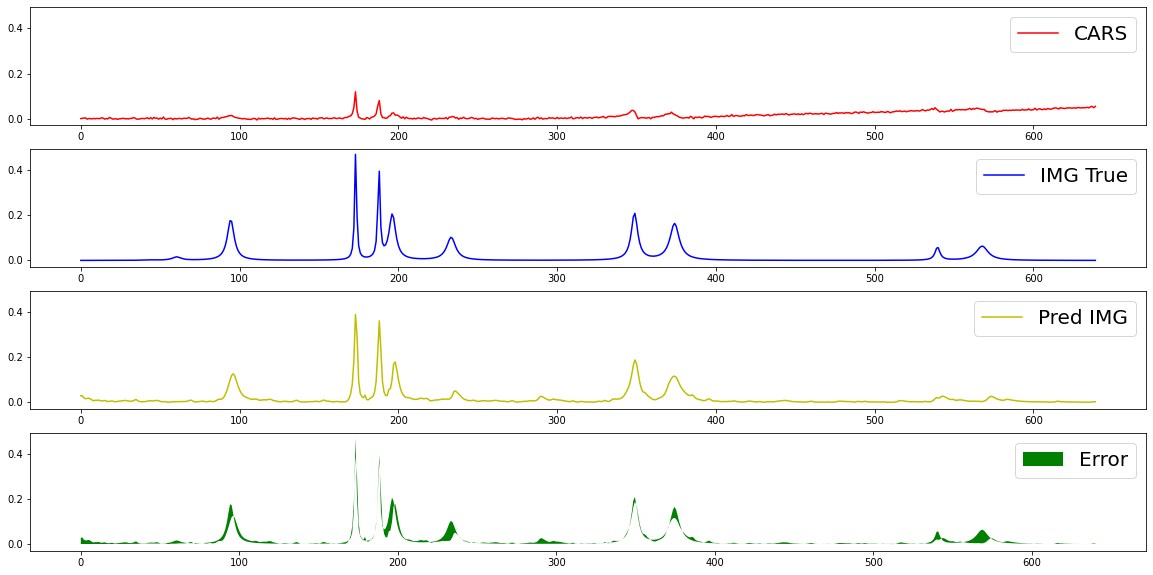

In [44]:
nu= np.linspace(0,640,640)
x_val, y_val= x_test[17].reshape((1,640,1)), y_test[17].reshape((1,640,1))
y_prd= saved_model_lstm.predict(x_val)
f, ax=plt.subplots(4,1, sharey=True, figsize=(20,10))
ax[0].plot(x_val[0,:,0], c='r', label='CARS')
ax[0].legend(fontsize=20)
ax[1].plot(y_val[0,:,0], c='b', label='IMG True')
ax[1].legend(fontsize=20)
ax[2].plot(y_prd[0,:,0], c='y', label= 'Pred IMG')
ax[2].legend(fontsize=20)
ax[3].fill_between(nu,y_val[0,:,0],y_prd[0,:,0], facecolor='green', label='Error')
ax[3].legend(fontsize=20)
plt.savefig('lstm.jpeg')
plt.show()

In [19]:
# we will use the difference of areas between the predicted  and the reel data: Similarity measure
def metric(x,y):
    x,y= x.reshape((-1,640)), y.reshape((-1,640))
    a= 0.0
    for i in range(len(x)):
        for j in range(x.shape[1]-1):
            a+=np.abs((x[i,j+1]+x[i,j])-(y[i,j+1]+y[i,j]))/2.0
    return a/len(x)

In [47]:
y_hat= saved_model_lstm.predict(x_test)
metric= metric(y_test, y_hat)
metric

4.9296394483506045

### Random prediction

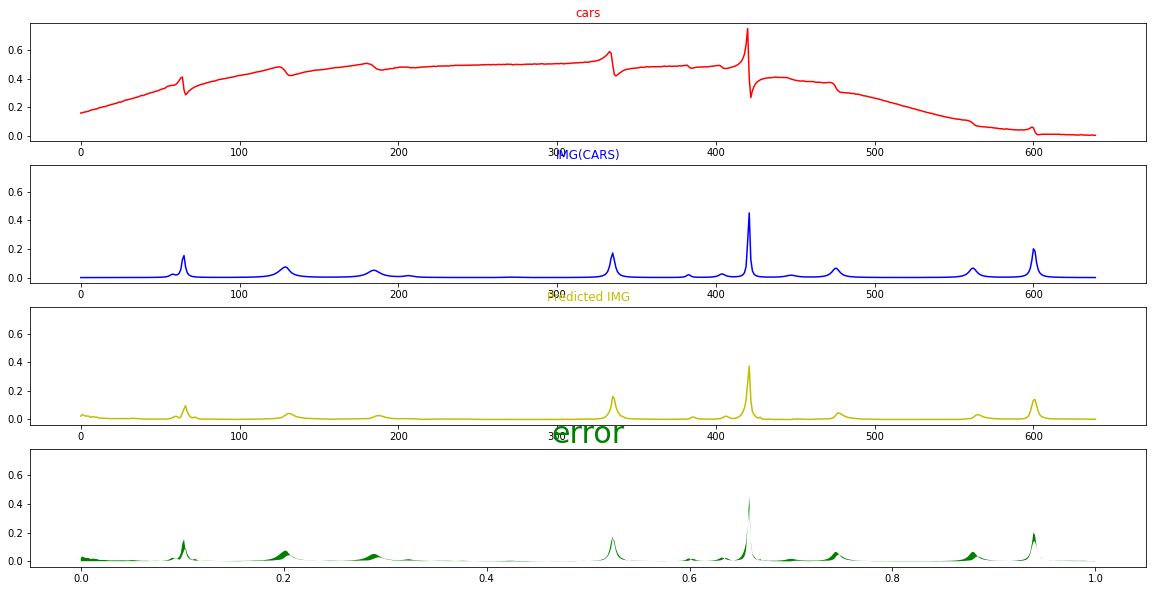

In [44]:
cars=cars_generating(15,640)
data= cars.generate_batch(1)
nu=cars.nu
x= data[0]
y=data[1]
x_gen, y_gen= x.reshape((-1,640,1)), y.reshape((-1,640,1))
y_pred=saved_model_lstm.predict(x_gen)
f, ax=plt.subplots(4,1, sharey=True, figsize=(20,10))
ax[0].plot(x_gen[0,:,0], c='r')
ax[0].set_title("cars", c='r')
ax[1].plot(y_gen[0,:,0], c='b')
ax[1].set_title("IMG(CARS)", c='b')
ax[2].plot(y_pred[0,:,0], c='y')
ax[2].set_title('Predicted IMG', c='y')
ax[3].fill_between(nu,y_gen[0,:,0],y_pred[0,:,0], facecolor='green')
ax[3].set_title('error', c='green', fontsize=30)
plt.show()

# CNN+LSTM #

### Model Architecture

In [33]:
logdir2 = "logs/scalars/CNN_LSTM" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback1 = tf.keras.callbacks.TensorBoard(log_dir=logdir2)
es1 =tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode= 'min', min_delta=0.0001)
rmse= tf.keras.metrics.RootMeanSquaredError()
mc2 = ModelCheckpoint('CNN+LSTM.h5', monitor='val_loss', mode='min', save_best_only=True)
tf.keras.backend.clear_session()
input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]))
conv1 = Conv1D(filters=128,
               kernel_size=32,
               strides=1,
               activation='relu',
               padding='same')(input_layer)
conv2= Conv1D(filters=64, kernel_size=16, activation='relu', padding='same')(conv1)
conv3= Conv1D(filters=16, kernel_size=8, activation='relu', padding='same')(conv2)
conv4= Conv1D(filters=8, kernel_size=4, activation='relu', padding='same')(conv3)
lstm1 = LSTM(50, return_sequences=True)(conv4)
lstm2=LSTM(30,return_sequences=True)(lstm1)
dens1=Dense(30, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1 = 0, l2=0.1))(lstm2)
output_layer = TimeDistributed(Dense(units=1))(dens1)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss= 'mse', metrics=[rmse])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 640, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 640, 128)          4224      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 640, 64)           131136    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 640, 16)           8208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 640, 8)            520       
_________________________________________________________________
lstm (LSTM)                  (None, 640, 50)           11800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 640, 30)          

In [34]:
CNN_LSTM_history= model.fit(x_train, y_train, epochs=50, batch_size=128, verbose=2, 
                         validation_split=0.2, callbacks=[es1, mc2, tb_callback1])

Epoch 1/50
84/84 - 94s - loss: 2.0786 - root_mean_squared_error: 0.0471 - val_loss: 1.3051 - val_root_mean_squared_error: 0.0308
Epoch 2/50
84/84 - 96s - loss: 0.8689 - root_mean_squared_error: 0.0254 - val_loss: 0.5234 - val_root_mean_squared_error: 0.0213
Epoch 3/50
84/84 - 93s - loss: 0.3362 - root_mean_squared_error: 0.0186 - val_loss: 0.1918 - val_root_mean_squared_error: 0.0170
Epoch 4/50
84/84 - 93s - loss: 0.1183 - root_mean_squared_error: 0.0167 - val_loss: 0.0634 - val_root_mean_squared_error: 0.0167
Epoch 5/50
84/84 - 93s - loss: 0.0375 - root_mean_squared_error: 0.0162 - val_loss: 0.0190 - val_root_mean_squared_error: 0.0166
Epoch 6/50
84/84 - 94s - loss: 0.0109 - root_mean_squared_error: 0.0164 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0166
Epoch 7/50
84/84 - 93s - loss: 0.0031 - root_mean_squared_error: 0.0160 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0156
Epoch 8/50
84/84 - 96s - loss: 0.0010 - root_mean_squared_error: 0.0153 - val_loss: 6.3937e-04 - 

### Evaluate the cnn+lstm model with RMSE and difference areas

In [35]:
saved_model_cnn_lstm = load_model('CNN+LSTM.h5')
CNN_LSTM_valuation=saved_model_cnn_lstm.evaluate(x_test, y_test, batch_size=128, verbose=2)
CNN_LSTM_valuation

53/53 - 13s - loss: 1.6202e-04 - root_mean_squared_error: 0.0093


[0.00016201817197725177, 0.009256940335035324]

In [48]:
saved_model_cnn_lstm = load_model('CNN+LSTM.h5')

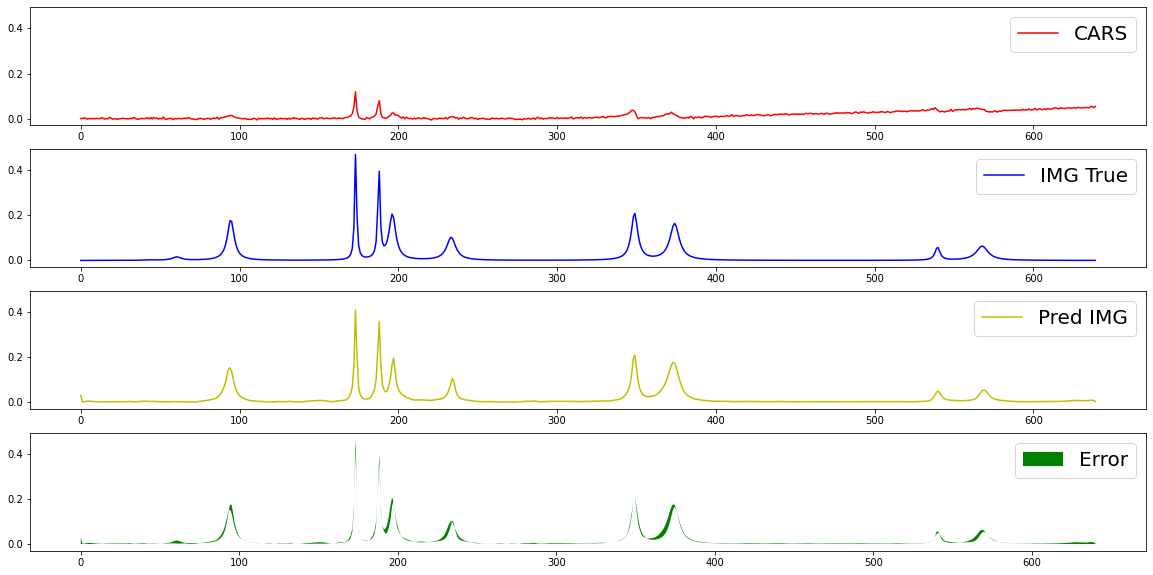

In [48]:
saved_model_cnn_lstm = load_model('CNN+LSTM.h5')
x_val, y_val= x_test[17].reshape((1,640,1)), y_test[17].reshape((1,640,1))
y_prd= saved_model_cnn_lstm.predict(x_val)
f, ax=plt.subplots(4,1, sharey=True, figsize=(20,10))
ax[0].plot(x_val[0,:,0], c='r', label='CARS')
ax[0].legend(fontsize=20)
ax[1].plot(y_val[0,:,0], c='b', label='IMG True')
ax[1].legend(fontsize=20)
ax[2].plot(y_prd[0,:,0], c='y', label= 'Pred IMG')
ax[2].legend(fontsize=20)
ax[3].fill_between(nu,y_val[0,:,0],y_prd[0,:,0], facecolor='green', label='Error')
ax[3].legend(fontsize=20)
plt.savefig('cnn+lstm.jpeg')

In [51]:
# Simiarity measure
y_hat= saved_model_cnn_lstm.predict(x_test)
metric_cnn_lsmt= metric(y_test, y_hat)
metric_cnn_lsmt

2.3862205617427446

### Rnadom prediction

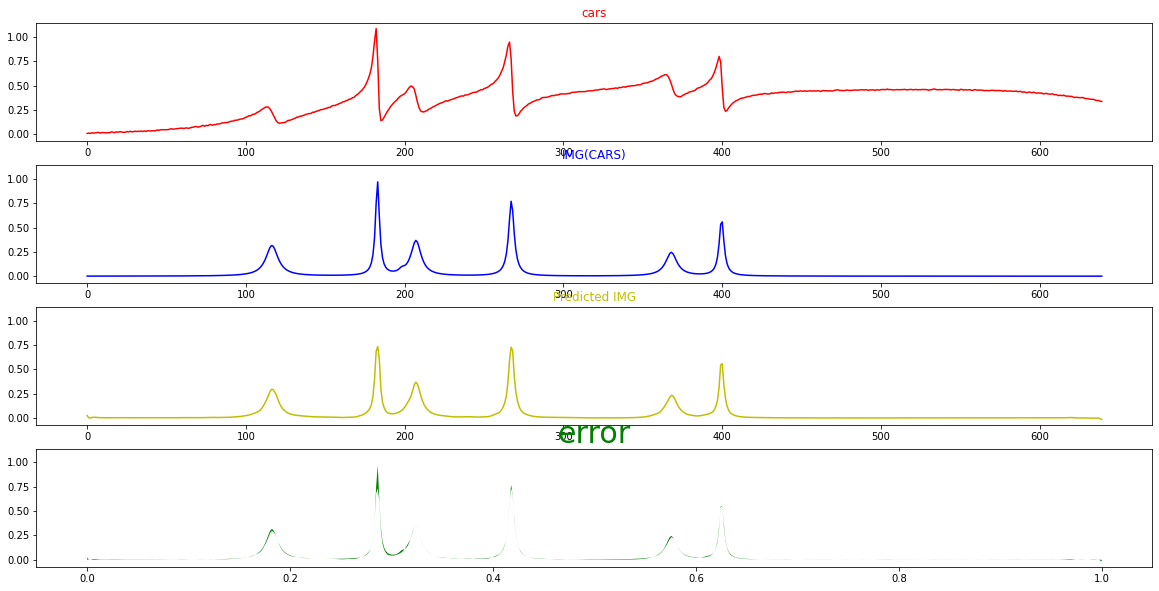

In [41]:
cars=cars_generating(7,640)
data= cars.generate_batch(1)
nu=cars.nu
x= data[0]
y=data[1]
x_gen, y_gen= x.reshape((-1,640,1)), y.reshape((-1,640,1))
y_pred=saved_model_cnn_lstm.predict(x_gen)
f, ax=plt.subplots(4,1, sharey=True, figsize=(20,10))
ax[0].plot(x_gen[0,:,0], c='r')
ax[0].set_title("cars", c='r')
ax[1].plot(y_gen[0,:,0], c='b')
ax[1].set_title("IMG(CARS)", c='b')
ax[2].plot(y_pred[0,:,0], c='y')
ax[2].set_title('Predicted IMG', c='y')
ax[3].fill_between(nu,y_gen[0,:,0],y_pred[0,:,0], facecolor='green')
ax[3].set_title('error', c='green', fontsize=30)
plt.show()

# CNN polimi

### Load CNN Model and evaluate it 

In [11]:
n_points=640
rmse= tf.keras.metrics.RootMeanSquaredError()
mc = ModelCheckpoint('model_poli2.h5', monitor='val_loss', mode='min', save_best_only=True)
tf.keras.backend.clear_session()
model = Sequential()

model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001,
                             center=True, scale=True, beta_initializer='zeros', 
                             gamma_initializer='ones', moving_mean_initializer='zeros', 
                             moving_variance_initializer='ones', beta_regularizer=None, 
                             gamma_regularizer=None, beta_constraint=None, gamma_constraint=None,
                             input_shape = (n_points, 1), name='batch_normalization'))

model.add(Activation('relu', name='activation'))

model.add(Conv1D(128, activation = 'relu', kernel_size = (32), name='conv1d'))
model.add(Conv1D(64, activation = 'relu', kernel_size = (16), name='conv1d_1'))
model.add(Conv1D(16, activation = 'relu', kernel_size = (8), name='conv1d_2'))
model.add(Conv1D(16, activation = 'relu', kernel_size = (8), name='conv1d_3'))
model.add(Conv1D(16, activation = 'relu', kernel_size = (8), name='conv1d_4'))
model.add(Dense(32, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1 = 0, l2=0.1), name='dense'))
model.add(Dense(16, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1 = 0, l2=0.1), name='dense_1'))
model.add(Flatten(name='flatten'))
model.add(Dropout(.25, name='dropout'))
model.add(Dense(n_points, activation='relu', name='dense_2'))
model.load_weights('Specnet_weights.h5')
model.compile(loss='mse', optimizer='Adam', metrics=[rmse,'accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 640, 1)            4         
_________________________________________________________________
activation (Activation)      (None, 640, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 609, 128)          4224      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 594, 64)           131136    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 587, 16)           8208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 580, 16)           2064      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 573, 16)           2

In [16]:
# scenario1: load the weihts and evaluate the modelwithout training
x_test, y_test= x_test.reshape((-1,640,1)), y_test.reshape((-1,640))
CNN_valuation=model.evaluate(x_test, y_test, batch_size=128, verbose=2)
CNN_valuation

53/53 - 5s - loss: 0.0020 - root_mean_squared_error: 0.0441 - accuracy: 0.6867


[0.002004323760047555, 0.04406559839844704, 0.6867415904998779]

In [22]:
# Scenario2: load the weights and retrain on a diffeent 50k samples (rplica of the polimi model)
saved_model_cnn = load_model('model_poli1.h5')
CNN_valuation1=saved_model_cnn.evaluate(x_test, y_test, batch_size=128, verbose=2)
CNN_valuation1

53/53 - 6s - loss: 5.8696e-04 - root_mean_squared_error: 0.0233 - accuracy: 0.7441


[0.0005869595916010439, 0.023338062688708305, 0.7441198229789734]

In [23]:
# Scenario3: Load the weights and train on 20k samples as other models
saved_model_cnn1 = load_model('model_CCN_poli.h5')
CNN_valuation2=saved_model_cnn1.evaluate(x_test, y_test, batch_size=128, verbose=2)
CNN_valuation2

53/53 - 5s - loss: 8.4936e-04 - root_mean_squared_error: 0.0284 - accuracy: 0.6497


[0.0008493561181239784, 0.028448497876524925, 0.6497378349304199]

In [20]:
# Similarity measure for scenario1
y_hat= model.predict(x_test)
metric_cnn= metric(y_test, y_hat)
metric_cnn

10.452667264729724

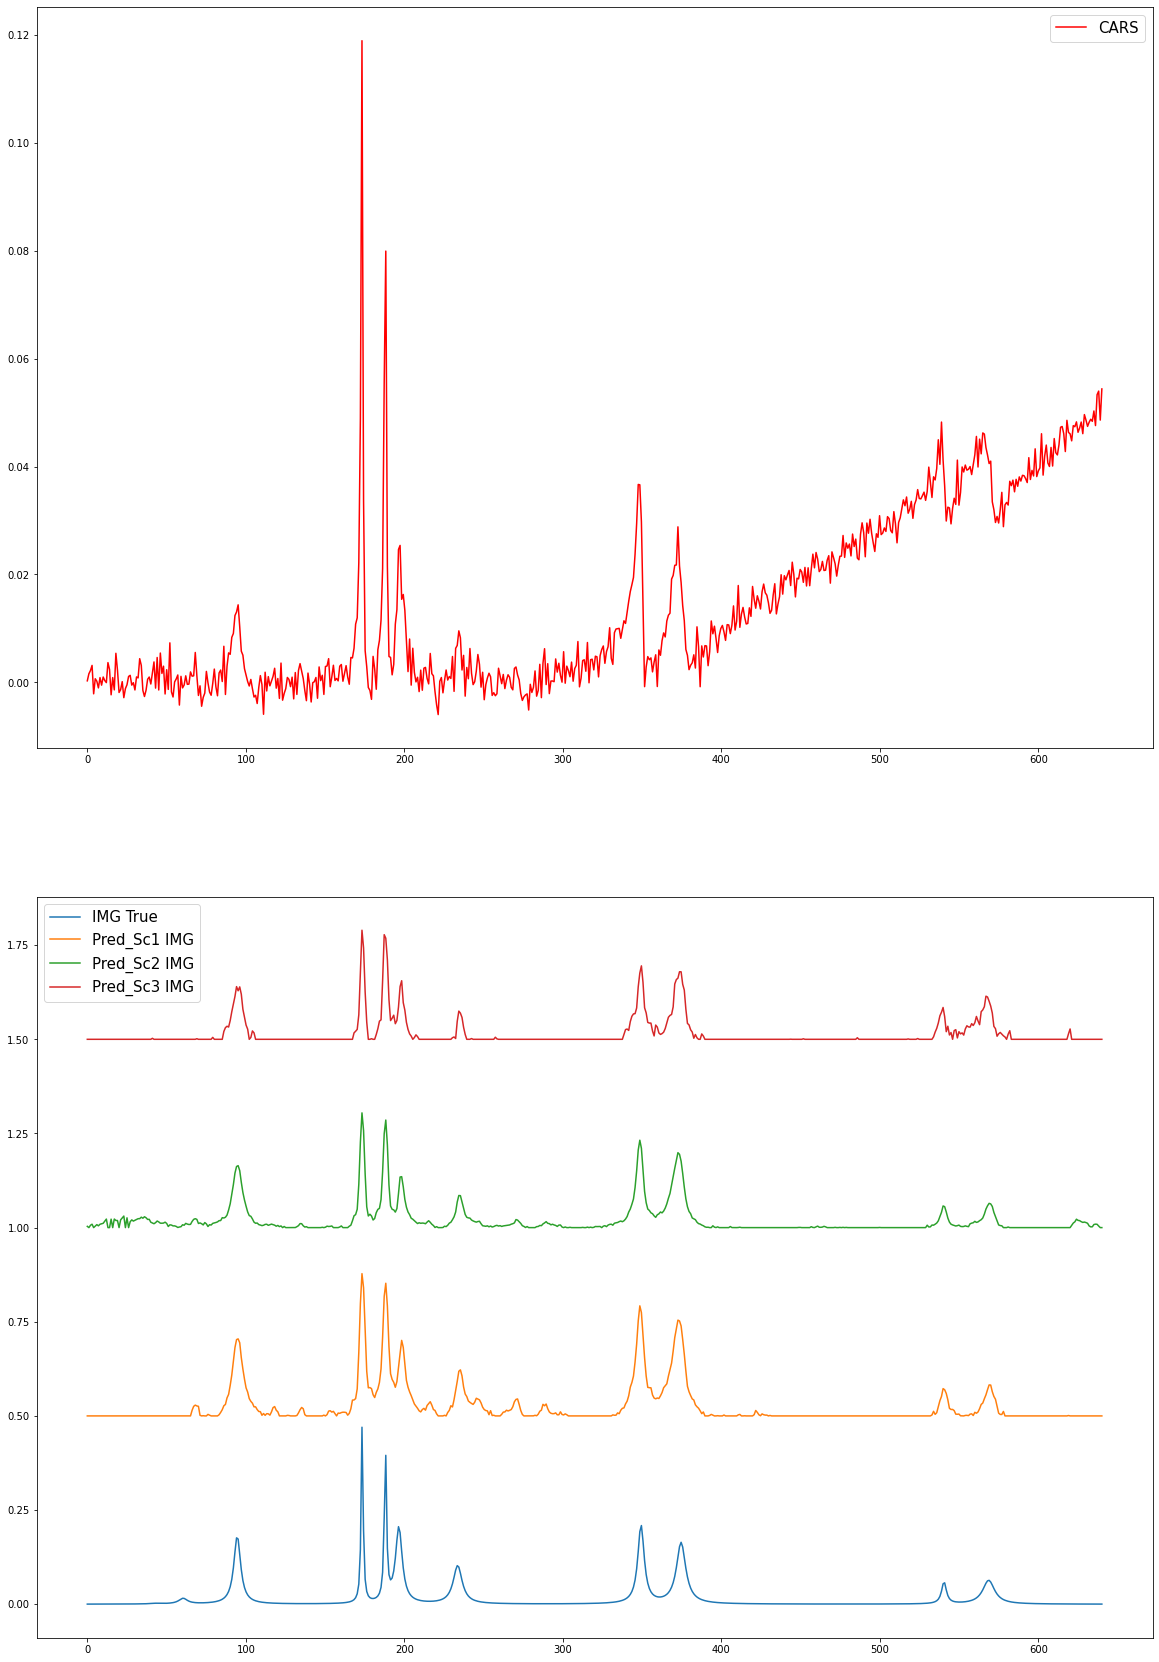

In [45]:
nu=np.linspace(0,640,640)
x_val, y_val= x_test[17].reshape((1,640,1)), y_test[17].reshape((1,640))
y_prd1= model.predict(x_val)
y_prd2= saved_model_cnn(x_val)
y_prd3= saved_model_cnn1(x_val)
f, ax1=plt.subplots(nrows=2, figsize=(20,30))
ax1[0].plot(nu,x_val[0,:,0], c='r', label='CARS')
ax1[0].legend(fontsize=15)
ax1[1].plot(nu,y_val[0], label='IMG True')
ax1[1].legend(fontsize=15)
ax1[1].plot(nu,y_prd1[0]+0.5, label= 'Pred_Sc1 IMG')
ax1[1].legend(fontsize=15)
ax1[1].plot(nu,y_prd2[0]+1., label= 'Pred_Sc2 IMG')
ax1[1].legend(fontsize=15)
ax1[1].plot(nu,y_prd3[0]+1.5, label= 'Pred_Sc3 IMG')
ax1[1].legend(fontsize=15)
plt.savefig('cnn1.jpeg')
plt.show()

### Rndom prediction 

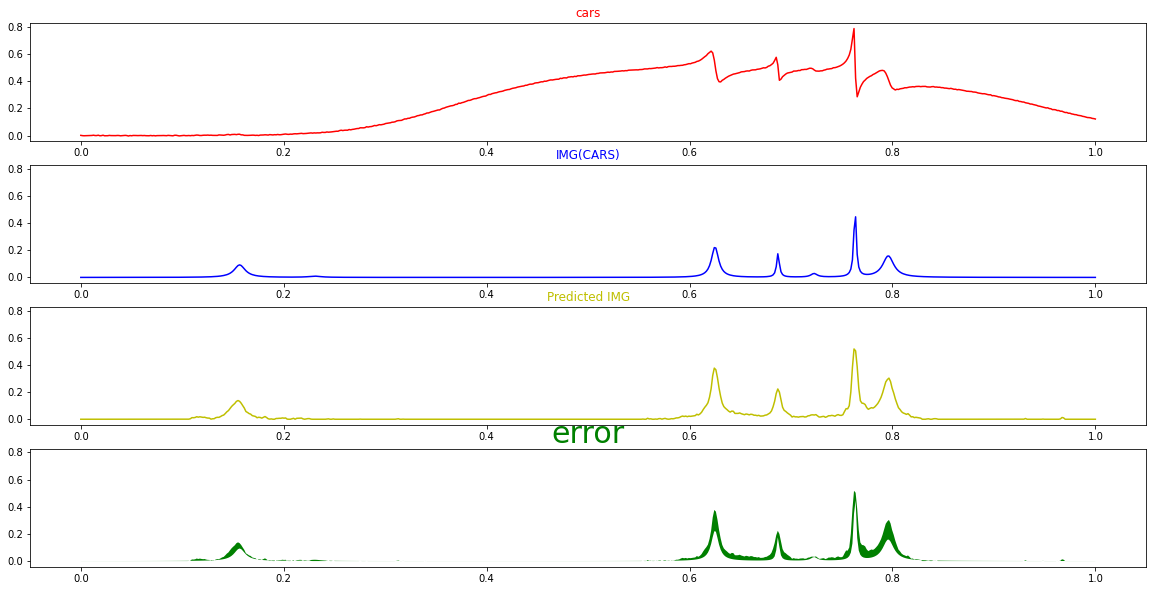

In [21]:
cars=cars_generating(7,640)
data= cars.generate_batch(1)
nu=cars.nu
x= data[0]
y=data[1]
x_gen, y_gen= x.reshape((-1,640,1)), y.reshape((-1,640))
y_pred=model.predict(x_gen)
f, ax=plt.subplots(4,1, sharey=True, figsize=(20,10))
ax[0].plot(nu,x_gen[0,:,0], c='r')
ax[0].set_title("cars", c='r')
ax[1].plot(nu,y_gen[0], c='b')
ax[1].set_title("IMG(CARS)", c='b')
ax[2].plot(nu,y_pred[0], c='y')
ax[2].set_title('Predicted IMG', c='y')
ax[3].fill_between(nu,y_gen[0],y_pred[0], facecolor='green')
ax[3].set_title('error', c='green', fontsize=30)
plt.show()

# history PLot of the models

In [55]:
%tensorboard --logdir logs

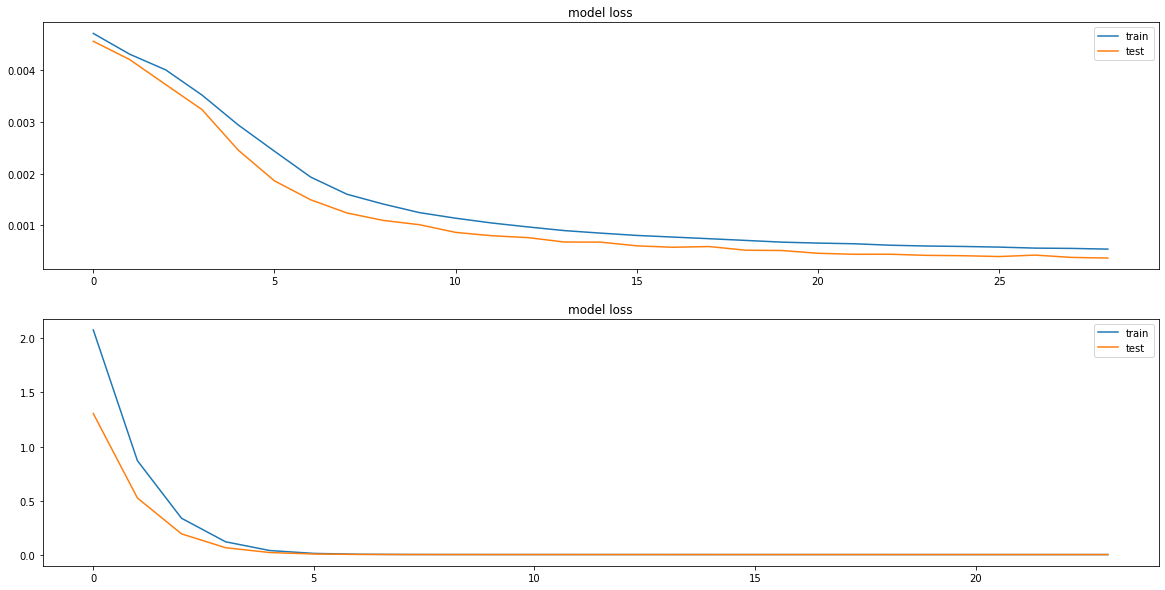

In [61]:
f, ax= plt.subplots(2,1, figsize=(20,10))
ax[0].plot(history_lstm.history['loss'])
ax[0].plot(history_lstm.history['val_loss'])
ax[0].set_title('model loss')
ax[0].legend(['train', 'test'], loc='upper right')

ax[1].plot(CNN_LSTM_history.history['loss'])
ax[1].plot(CNN_LSTM_history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].legend(['train', 'test'], loc='upper right')

plt.show()

# Comparison result

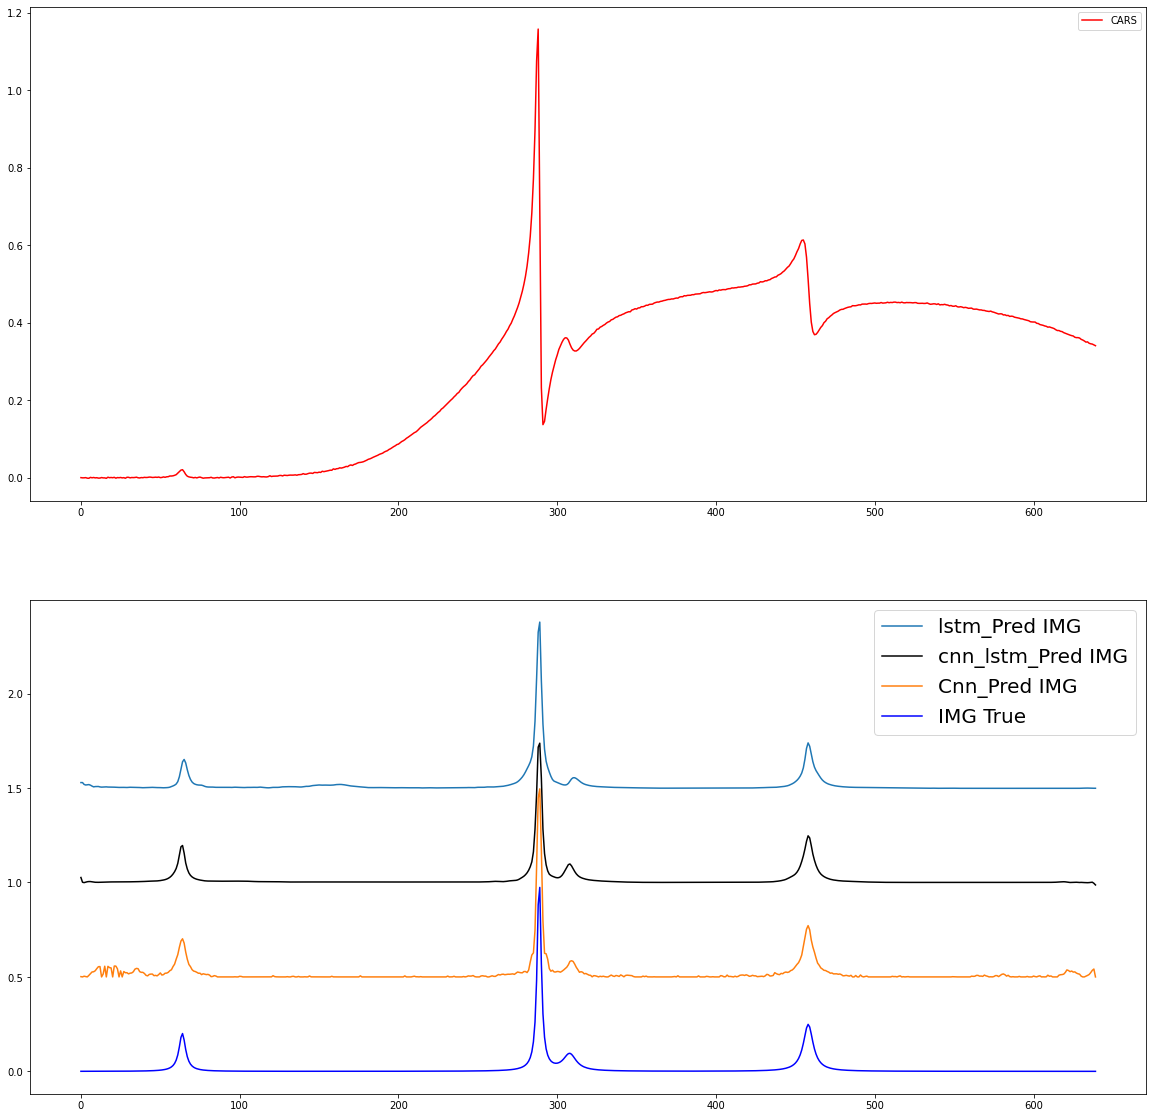

In [89]:
x,y=data_feature_generation(1,4)
nu= np.linspace(0,640,640)
x_val, y_val= x.reshape((1,640,1)), y.reshape((1,640,1))
y_prd_lstm= saved_model_lstm.predict(x_val)
y_prd_lstmcnn=saved_model_cnn_lstm.predict(x_val)
x_val, y_val= x.reshape((1,640,1)), y.reshape((1,640))
y_prd_cnn=saved_model_cnn.predict(x_val)
f, ax=plt.subplots(2,1, sharey=False,sharex=False, figsize=(20,20))
ax[0].plot(x_val[0,:,0], c='r', label='CARS')
ax[0].legend(fontsize=10)
ax[1].plot(y_prd_lstm[0,:,0]+1.5, label= 'lstm_Pred IMG')
ax[1].plot(y_prd_lstmcnn[0,:,0]+1,c='black', label= 'cnn_lstm_Pred IMG')
ax[1].plot(y_prd_cnn[0]+0.5, label= 'Cnn_Pred IMG')
ax[1].plot(y_val[0],c='b', label='IMG True')
ax[1].legend(fontsize=20)
plt.savefig('compar.jpeg')
plt.show()